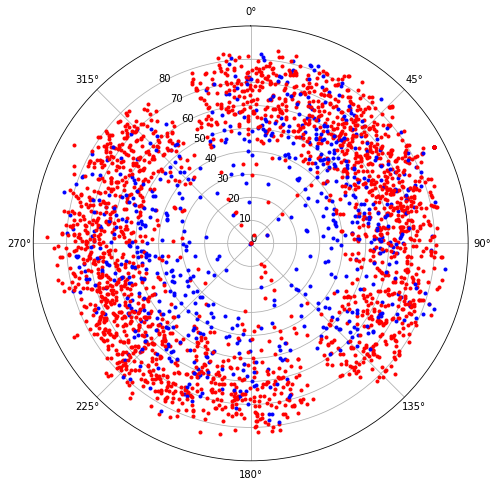

In [8]:
import ROOT
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import iy10_ultrashower_utilities as shower
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

# Defining data structure
class TxtFile:
    def __init__(self):
        self.column1 = 0
        self.column2 = 0
        self.column3 = 0
        self.column4 = 0
        self.column5 = 0
        self.column6 = 0.0
        self.column7 = 0.0
        self.column8 = 0.0
        self.column9 = 0.0
        self.column10 = 0.0
        self.column11 = 0.0
        self.column12 = 0
        
# Function for creating and saving Altitude and Azimuth
def GoodBad(df, x_column, y_column, x_angle, y_angle, t, output_path):
    #variables
    good_angles = []
    bad_angles = []
    good_altaz = []
    bad_altaz = []
    good_radec = []
    bad_radec = []
    good_timestamp = []
    bad_timestamp = [] 
    for _, row in df.iterrows():
        if row[x_angle] == 0.0 and row[y_angle] == 0.0:
            continue
        if np.sqrt(row[x_column]**2+row[y_column]**2) < 0.06:
            good_angles.append((row[x_angle], row[y_angle]))
            good_timestamp.append((row[t]))
            good_altaz.append(shower.GetAltAz(row[x_angle], row[y_angle]))
        else:
            bad_angles.append((row[x_angle], row[y_angle]))
            bad_timestamp.append((row[t]))
            bad_altaz.append(shower.GetAltAz(row[x_angle], row[y_angle]))
    # Save the lists into text files
    np.savetxt(output_path + "GoodAngles1.txt", good_angles, fmt='%0.3f')
    np.savetxt(output_path + "GoodTimestamp1.txt", good_timestamp)
    np.savetxt(output_path + "GoodAltAz1.txt", good_altaz, fmt='%0.3f')
    np.savetxt(output_path + "BadAngles1.txt", bad_angles, fmt='%0.3f')
    np.savetxt(output_path + "BadTimestamp1.txt", bad_timestamp)
    np.savetxt(output_path + "BadAltAz1.txt", bad_altaz, fmt='%0.3f')

def PolarAltAz(df, x_column, y_column, x_angle, y_angle, output_path):
    if len(df.columns) == 0:
        print("Dataframe is empty. Skipping this file")
        return
    
    def get_altaz_color(row):
        x = float(row[x_column])
        y = float(row[y_column])
        angX = float(row[x_angle])
        angY = float(row[y_angle])
        distance = np.sqrt(x**2 + y**2)
        alt, az = shower.GetAltAz(angX, angY)
        color = 'red' if distance >= 0.06 else 'green'
        return alt, az, color

    altaz_values = df.apply(get_altaz_color, axis=1, meta='object').compute()
    altitude = np.array([alt for alt, _, _ in altaz_values])
    azimuth = np.array([az for _, az, _ in altaz_values])
    colors = np.array([c for _, _, c in altaz_values])
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='polar') #Draw polar graph
    
    for alt, az, color in zip(altitude, azimuth, colors):
        theta = np.radians(az + 90)  # Add 90 degrees to convert to standard polar coordinate system
        r = alt
        marker = 'o' if color == 'red' else 'o'  # Choose marker style based on color
        c = 'r' if color == 'red' else 'b'  # Choose color based on color

        ax.plot(theta, r, marker=marker, color=c, markersize=3)
    
    ax.set_theta_zero_location('N')  # Set the azimuth zero to the north
    ax.set_theta_direction(-1)  # Set the azimuth direction to clockwise
    ax.set_rticks(np.arange(0, 90, 10))  # Set radial ticks/gridlines at specific angles
    ax.set_rlabel_position(-30)  # Set radial label position
    ax.grid(True)

    plt.savefig(os.path.join(output_path, "PolarAltitudeAzimuth.png"))
    plt.show()

# Directory where txt files are located
file_list = glob.glob("/home/aklima/Muon_Shower_Data/TextFiles/*_EventInfo.txt")

# Directory to save histograms
output_path = "/home/aklima/Muon_Shower_Data/Combined_histograms/"

# Process files in batches to avoid memory issues 
batch_size = 10
dfs = []
for n in range(0, len(file_list), batch_size):
    batch_file_path = file_list[n:n+batch_size]
    for file_path in batch_file_path:
        df = dd.read_csv(file_path, delimiter='\t', comment='#', names=["Run","Subrun","Event","SubStart","SubStop","Occupancy_XZ","Occupancy_YZ","AsymXZ","AsymYZ","Angle_XZ","Angle_YZ","Timestamp"])

        if len(df.columns) > 0:
            dfs.append(df)

combined_df = dd.concat(dfs)
GoodBad(combined_df, 'AsymXZ', 'AsymYZ','Angle_XZ', 'Angle_YZ', 'Timestamp', output_path)
PolarAltAz(combined_df, 'AsymXZ', 'AsymYZ', 'Angle_XZ', 'Angle_YZ', output_path)